### Parameter Tuning and Model Selection

In this Jupyter Notebook, cleaned data done in previous notebook will be used for model creation, hyperparameter tuning and choose the best model for prediction.

### Import package

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score,roc_curve,confusion_matrix,plot_confusion_matrix,classification_report,precision_score,recall_score,f1_score,accuracy_score,plot_roc_curve, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

### Read traning and testing dataset

In [62]:
train = pd.read_csv('clean_train.csv')
test = pd.read_csv('clean_test.csv')

### Split dataset into x and y variable

In [63]:
x_train = train.drop(columns=['Churn'])
y_train = train['Churn']
x_test = test.drop(columns=['Churn'])
y_test = test['Churn']

#### For this project, classification model that will be used are:
- Logistic Regression -- probability of input occur in certain class
- Decision Tree -- using a tree like model, show possible consequences of decision
- Random Forest -- randomly creates and merge multiple decision trees

### Model fitting (with default parameter)

In [64]:
logistic = LogisticRegression()
dec_tree = DecisionTreeClassifier()
ran_forest = RandomForestClassifier()

### Fit training dataset with model

In [65]:
logistic.fit(x_train,y_train)
dec_tree.fit(x_train,y_train)
ran_forest.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Check cross validation score between model

In [66]:
log_cv_0 = cross_val_score(logistic,x_train,y_train,cv=5)*100
tree_cv_0 = cross_val_score(dec_tree,x_train,y_train,cv=5)*100
forest_cv_0 = cross_val_score(ran_forest,x_train,y_train,cv=5)*100

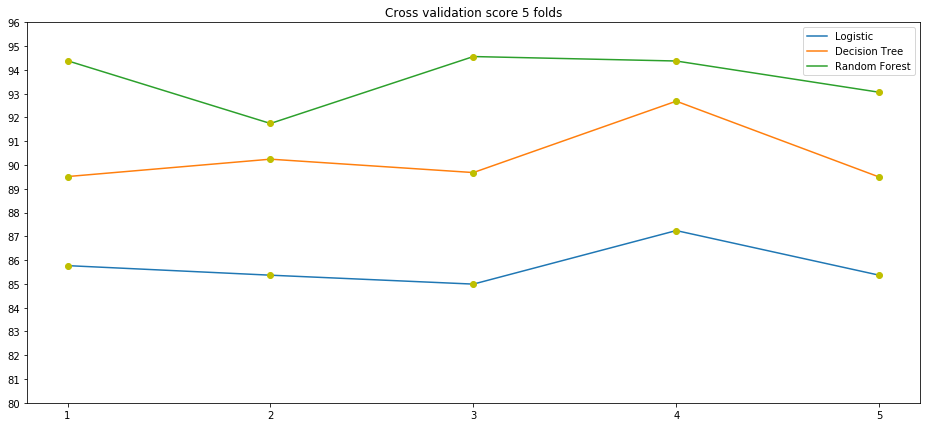

In [67]:
plt.figure(figsize=(16,7))
plt.title('Cross validation score 5 folds')
plt.plot([1,2,3,4,5],log_cv_0)
plt.plot([1,2,3,4,5],tree_cv_0)
plt.plot([1,2,3,4,5],forest_cv_0)
plt.plot([1,2,3,4,5],log_cv_0,'yo')
plt.plot([1,2,3,4,5],tree_cv_0,'yo')
plt.plot([1,2,3,4,5],forest_cv_0,'yo')
plt.legend(['Logistic','Decision Tree','Random Forest'])
plt.xticks(np.arange(1,6))
plt.yticks(np.arange(80,97,1))
plt.show()

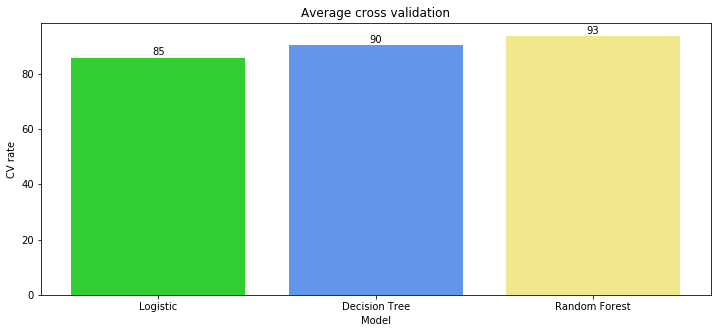

In [68]:
plt.figure(figsize=(12,5))
plt.title('Average cross validation')
plot = plt.bar(['Logistic','Decision Tree','Random Forest'],[log_cv_0.mean(),tree_cv_0.mean(),forest_cv_0.mean()],color=['limegreen','cornflowerblue','khaki'])
plt.ylabel('CV rate')
plt.xlabel('Model')
for i in plot:
    height = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.,
             1.002*height,'%d'% int(height),ha='center',va='bottom' )
plt.show()

### Hyperparameter tuning

By changing model parameter to certain value, we hope that our model performance can improve in classifying churning rate.

For this project, RandomizedSearch will be used instead of GridSearch for time efficiency.

In [69]:
def tuning(model,parameter,n_cv):
    random = RandomizedSearchCV(model, parameter, cv = n_cv)
    random.fit(x_train,y_train)
    best_param = random.best_params_
    
    return best_param

#### Parameter for logistic regression

Parameter to be tested:

- solver
- max iteration

In [70]:
log_param = {
    'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
    'penalty':['none','l1','l2','elasticnet'],
    'C':[100,10,1.0,0.1,0.01]
}

log_best = tuning(logistic,log_param,5)

#### Parameter for decision tree

Parameter to be tested:

- criterion -- pick the best split in decision tree
- max_depths -- tree length (from root to leaf)

In [108]:
tree_param = {
    'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features':['sqrt','log2'],
    'min_samples_split': [i for i in range(2,21,2)],
    'min_samples_leaf': [i for i in range(1,12)],
    'criterion':['gini','entropy']
}

tree_best = tuning(dec_tree,tree_param,5)

#### Parameter for random forest

Parameter to be tested:

- n_estimators -- number of trees in forest
- min_sample_split -- minimum number of samples required to split an internal node/condition.
- min_samples_leaf -- minimum number of samples required to be at a leaf node/end.

In [109]:
forest_param = {
    'n_estimators': [10,100,1000],
    'min_samples_split': [i for i in range(2,21,2)],
    'min_samples_leaf': [i for i in range(1,12)],
    'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['sqrt','log2'],
    'criterion':['gini','entropy']
}

forest_best = tuning(ran_forest,forest_param,5)

### Best parameters according to RandomizedSearch

In [73]:
print(log_best)

{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}


In [74]:
log_new = LogisticRegression(solver='liblinear',penalty='l2',C=0.1)
log_new.fit(x_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [110]:
print(tree_best)

{'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 40, 'criterion': 'entropy'}


In [111]:
tree_new = DecisionTreeClassifier(min_samples_split=10,min_samples_leaf=8,max_features='sqrt',max_depth=40,criterion='entropy')
tree_new.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=40, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [112]:
print(forest_best)

{'n_estimators': 1000, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'gini'}


In [113]:
forest_new = RandomForestClassifier(n_estimators=1000,min_samples_split=6,min_samples_leaf=1,max_features='sqrt',max_depth=100,criterion='gini')
forest_new.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Comparing default parameters with hyperparameter tuning result

##### Accuracy with testing data

In [105]:
log_acc_0 = round(logistic.score(x_test,y_test)*100,2)
log_acc_1 = round(log_new.score(x_test,y_test)*100,2)

print('Logistic regression accuracy with default parameter',log_acc_0,'%')
print('Logistic regression accuracy with hyperparameter tuning',log_acc_1,'%')
print('After tuning, accuracy improve by around',round(log_acc_1-log_acc_0,2),'%')

Logistic regression accuracy with default parameter 84.26 %
Logistic regression accuracy with hyperparameter tuning 85.01 %
After tuning, accuracy improve by around 0.75 %


In [114]:
tree_acc_0 = round(dec_tree.score(x_test,y_test)*100,2)
tree_acc_1 = round(tree_new.score(x_test,y_test)*100,2)

print('Decision tree accuracy with default parameter',tree_acc_0,'%')
print('Decision tree accuracy with hyperparameter tuning',tree_acc_1,'%')
print('After tuning, accuracy improve by around',round(tree_acc_1-tree_acc_0,2),'%')

Decision tree accuracy with default parameter 92.05 %
Decision tree accuracy with hyperparameter tuning 86.81 %
After tuning, accuracy improve by around -5.24 %


In [115]:
forest_acc_0 = round(ran_forest.score(x_test,y_test)*100,2)
forest_acc_1 = round(forest_new.score(x_test,y_test)*100,2)

print('Random forest accuracy with default parameter',forest_acc_0,'%')
print('Random forest accuracy with hyperparameter tuning',forest_acc_1,'%')
print('After tuning, accuracy improve by around',round(forest_acc_1-forest_acc_0,2),'%')

Random forest accuracy with default parameter 93.1 %
Random forest accuracy with hyperparameter tuning 94.0 %
After tuning, accuracy improve by around 0.9 %


### Compare models after hyperparameter tuning

##### Cross validation

In [116]:
log_cv_1 = cross_val_score(log_new,x_train,y_train,cv=5)*100
tree_cv_1 = cross_val_score(tree_new,x_train,y_train,cv=5)*100
forest_cv_1 = cross_val_score(forest_new,x_train,y_train,cv=5)*100

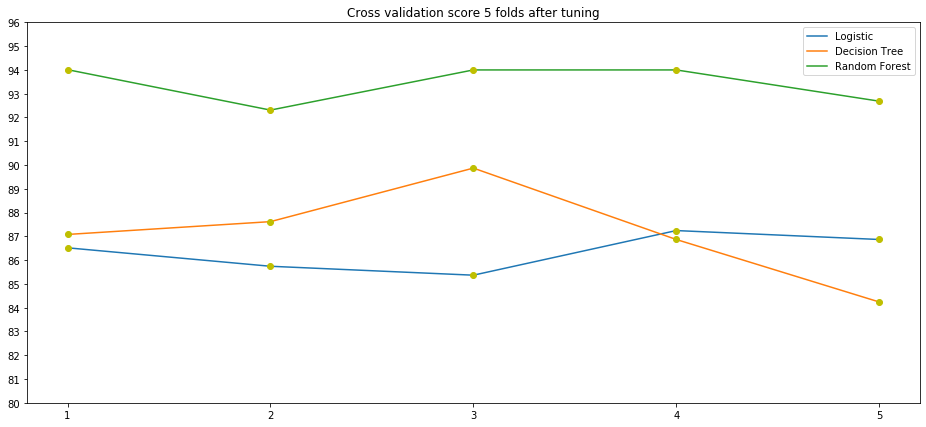

In [117]:
plt.figure(figsize=(16,7))
plt.title('Cross validation score 5 folds after tuning')
plt.plot([1,2,3,4,5],log_cv_1)
plt.plot([1,2,3,4,5],tree_cv_1)
plt.plot([1,2,3,4,5],forest_cv_1)
plt.plot([1,2,3,4,5],log_cv_1,'yo')
plt.plot([1,2,3,4,5],tree_cv_1,'yo')
plt.plot([1,2,3,4,5],forest_cv_1,'yo')
plt.legend(['Logistic','Decision Tree','Random Forest'])
plt.xticks(np.arange(1,6))
plt.yticks(np.arange(80,97,1))
plt.show()

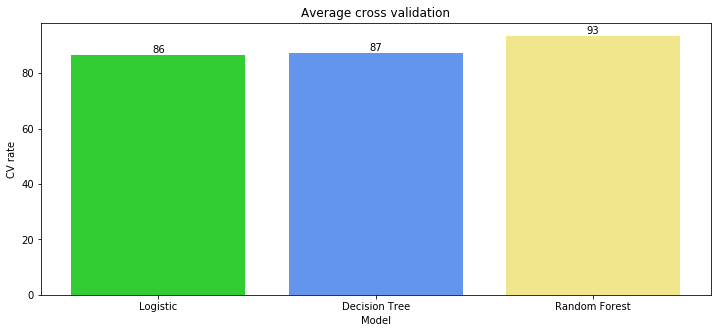

In [118]:
plt.figure(figsize=(12,5))
plt.title('Average cross validation')
plot = plt.bar(['Logistic','Decision Tree','Random Forest'],[log_cv_1.mean(),tree_cv_1.mean(),forest_cv_1.mean()],color=['limegreen','cornflowerblue','khaki'])
plt.ylabel('CV rate')
plt.xlabel('Model')
for i in plot:
    height = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.,
             1.002*height,'%d'% int(height),ha='center',va='bottom' )
plt.show()

### Confusion matrix

##### Logistic regression

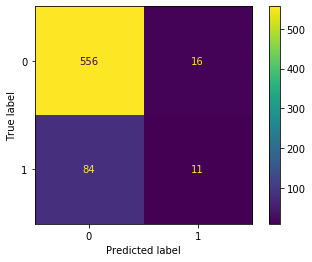

In [119]:
plot_confusion_matrix(log_new,x_test,y_test,values_format='0.0f')
plt.show()

##### Decision tree

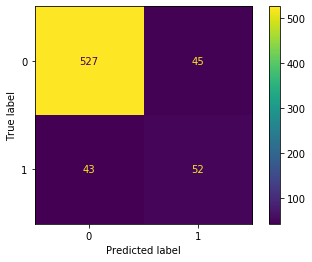

In [120]:
plot_confusion_matrix(tree_new,x_test,y_test,values_format='0.0f')
plt.show()

##### Random forest

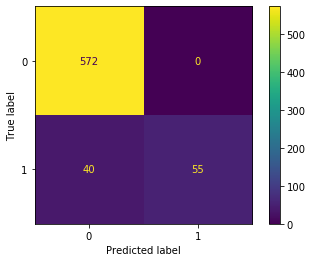

In [121]:
plot_confusion_matrix(forest_new,x_test,y_test,values_format='0.0f')
plt.show()

### Classification report

In [132]:
print('Classification report logistic regression:\n',classification_report(y_test,log_new.predict(x_test)))
print('Classification report Decision tree classifier:\n',classification_report(y_test,tree_new.predict(x_test)))
print('Classification report random forest classifier:\n',classification_report(y_test,forest_new.predict(x_test)))

Classification report logistic regression:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       572
           1       0.41      0.12      0.18        95

    accuracy                           0.85       667
   macro avg       0.64      0.54      0.55       667
weighted avg       0.80      0.85      0.81       667

Classification report Decision tree classifier:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       572
           1       0.54      0.55      0.54        95

    accuracy                           0.87       667
   macro avg       0.73      0.73      0.73       667
weighted avg       0.87      0.87      0.87       667

Classification report random forest classifier:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97       572
           1       1.00      0.58      0.73        95

    accuracy                           0

### Recall - If actual is 1, how many times can model predict 1?

Recall positive (sensitivity): $\displaystyle \frac {TP} {TP + FN}$

Recall negative (specificity): $\displaystyle \frac {TN} {TN + FP}$

In [133]:
log_recall_pos = recall_score(y_test,log_new.predict(x_test),pos_label=1)
log_recall_neg = recall_score(y_test,log_new.predict(x_test),pos_label = 0)
tree_recall_pos = recall_score(y_test,tree_new.predict(x_test),pos_label=1)
tree_recall_neg = recall_score(y_test,tree_new.predict(x_test),pos_label = 0)
forest_recall_pos = recall_score(y_test,forest_new.predict(x_test),pos_label=1)
forest_recall_neg = recall_score(y_test,forest_new.predict(x_test),pos_label = 0)

In [134]:
pd.DataFrame({'Logistic':[log_recall_pos,log_recall_neg],'Decision Tree':[tree_recall_pos,tree_recall_neg],'Random Forest':[forest_recall_pos,forest_recall_neg]},index=['churn','non churn'])

,Logistic,Decision Tree,Random Forest
churn,0.115789,0.547368,0.578947
non churn,0.972028,0.921329,1.000000


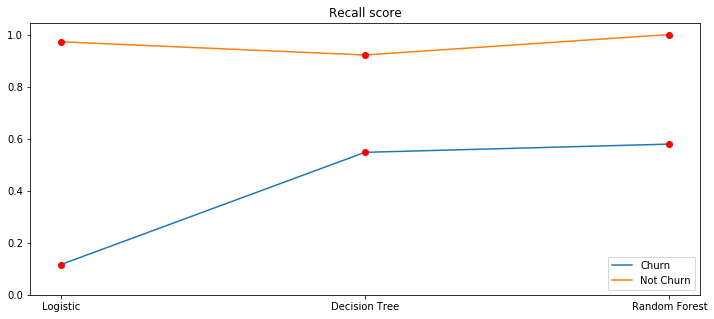

In [135]:
plt.figure(figsize=(12,5))
plt.title('Recall score')
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_recall_pos,tree_recall_pos,forest_recall_pos])
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_recall_neg,tree_recall_neg,forest_recall_neg])
plt.legend(['Churn','Not Churn'])
plt.plot([log_recall_pos,tree_recall_pos,forest_recall_pos],'ro')
plt.plot([log_recall_neg,tree_recall_neg,forest_recall_neg],'ro')
plt.yticks(np.arange(0,1.2,0.2))
plt.show()

### Precision - If prediction is 1 how many times it is right?


Formula Precision Positive = $\displaystyle \frac {TP}{TP+FP}$ 

Formula Precision Negative = $ \displaystyle \frac {TN}{TN+FN}$ 

In [136]:
log_prec_pos = precision_score(y_test,log_new.predict(x_test),pos_label=1)
log_prec_neg = precision_score(y_test,log_new.predict(x_test),pos_label=0)
tree_prec_pos = precision_score(y_test,tree_new.predict(x_test),pos_label=1)
tree_prec_neg = precision_score(y_test,tree_new.predict(x_test),pos_label=0)
forest_prec_pos = precision_score(y_test,forest_new.predict(x_test),pos_label=1)
forest_prec_neg = precision_score(y_test,forest_new.predict(x_test),pos_label=0)

In [137]:
pd.DataFrame({'Logistic':[log_prec_pos,log_prec_neg],'Decision Tree':[tree_prec_pos,tree_prec_neg],'Random Forest':[forest_prec_pos,forest_prec_neg]},index=['churn','non churn'])

,Logistic,Decision Tree,Random Forest
churn,0.407407,0.536082,1.000000
non churn,0.868750,0.924561,0.934641


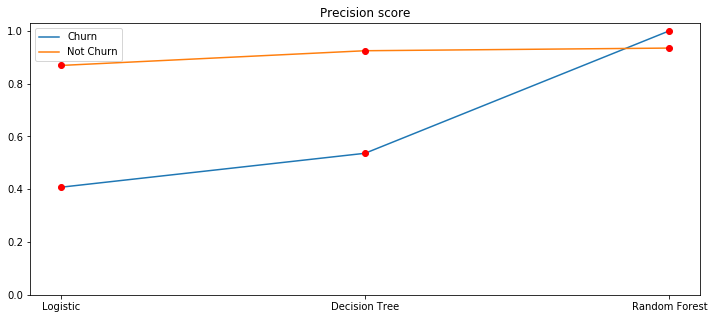

In [138]:
plt.figure(figsize=(12,5))
plt.title('Precision score')
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_prec_pos,tree_prec_pos,forest_prec_pos])
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_prec_neg,tree_prec_neg,forest_prec_neg])
plt.legend(['Churn','Not Churn'])
plt.plot([log_prec_pos,tree_prec_pos,forest_prec_pos],'ro')
plt.plot([log_prec_neg,tree_prec_neg,forest_prec_neg],'ro')
plt.yticks(np.arange(0,1.2,0.2))
plt.show()

##### Random forest produced the most precise prediction

### F1 Score - Harmonic mean between precision and recall

Formula = $\displaystyle 2 * (\frac {PrecisionP * RecallP }{PrecisionP + RecallP})$

In [139]:
f1_log_pos = f1_score(y_test,log_new.predict(x_test),pos_label=1)
f1_tree_pos = f1_score(y_test,tree_new.predict(x_test),pos_label=1)
f1_forest_pos = f1_score(y_test,forest_new.predict(x_test),pos_label=1)
f1_log_neg = f1_score(y_test,log_new.predict(x_test),pos_label=0)
f1_tree_neg = f1_score(y_test,tree_new.predict(x_test),pos_label=0)
f1_forest_neg = f1_score(y_test,forest_new.predict(x_test),pos_label=0)

In [140]:
pd.DataFrame({'Logistic':[f1_log_pos,f1_log_neg],'Decision Tree':[f1_tree_pos,f1_tree_neg],'Random Forest':[f1_forest_pos,f1_forest_neg]},index=['churn','not churn'])

,Logistic,Decision Tree,Random Forest
churn,0.180328,0.541667,0.733333
not churn,0.917492,0.922942,0.966216


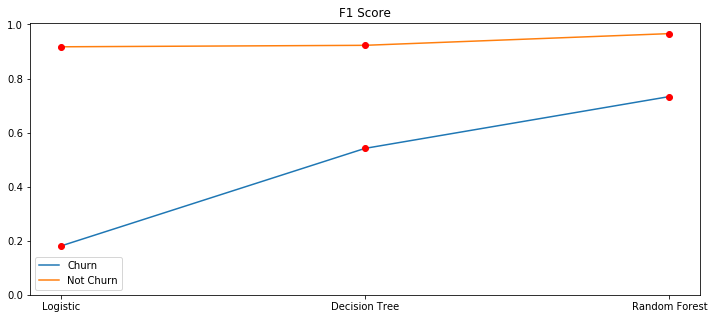

In [141]:
plt.figure(figsize=(12,5))
plt.title('F1 Score')
plt.plot(['Logistic','Decision Tree','Random Forest'],[f1_log_pos,f1_tree_pos,f1_forest_pos])
plt.plot(['Logistic','Decision Tree','Random Forest'],[f1_log_neg,f1_tree_neg,f1_forest_neg])
plt.plot([f1_log_pos,f1_tree_pos,f1_forest_pos],'ro')
plt.plot([f1_log_neg,f1_tree_neg,f1_forest_neg],'ro')
plt.yticks(np.arange(0,1.2,0.2))
plt.legend(['Churn','Not Churn'])
plt.show()

##### Logistic regression has the lowest f1 score in both positive and negative f1 score

### ROC AUC Score

Tells how much model is capable of distinguishing between classes. 

[sumber](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

TPR = $\displaystyle \frac {TP}{TP+FN}$

FPR = $\displaystyle \frac {FP}{FP+TN}$

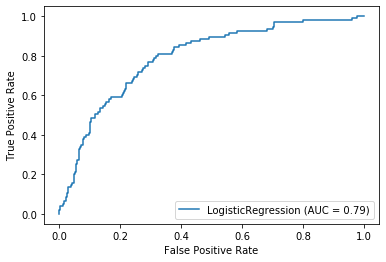

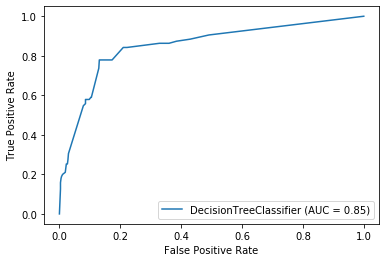

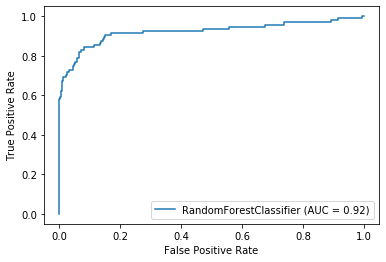

In [142]:
plot_roc_curve(log_new,x_test,y_test), plot_roc_curve(tree_new,x_test,y_test),plot_roc_curve(forest_new,x_test,y_test)
plt.show()

### Evaluation Metrics insight

After evaluating all metrics accross each model, I have chosen to use Random Forest.

Reason: 
- Higher F1 score in target 1 -> find characteristic of retaining customer.

### Feature importance

In [143]:
importance = pd.Series(forest_new.feature_importances_,x_train.columns).sort_values(ascending=False)
top10 = importance.head(10)*100
top10

day_charge        21.379865
CS_calls          12.041628
eve_charge         7.240578
intl_charge        7.024791
intl_call          6.085520
intl_Yes           5.292477
intl_No            5.202915
night_charge       4.904285
day_call           4.104225
Account_length     4.082784
dtype: float64

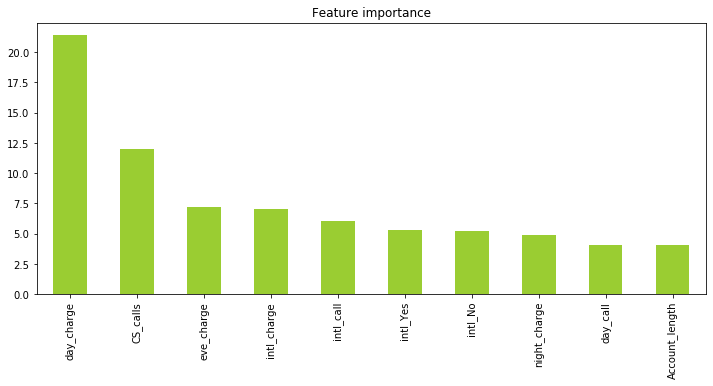

In [144]:
plt.figure(figsize=(12,5))
plt.title('Feature importance')
top10.plot(kind='bar',color=['yellowgreen'])
plt.show()

According to feature importance, day charges is the most determining factor in customer churning, followed by customer service calls made. 

#### Key Assumption:
1. Many churning customers feel that company day charge is too expensive, in comparison with other networks.
2. Customer with more customer service calls tend to churn due to customer experience issue or complaints made due to company's charging or network.
3. Company's international service might have recurring issues that make customer unhappy, in both network and pricing.

#### Recommendation

1. Company need to monitor customer who made customer service calls -- Many CS calls could indicate that there is something wrong with the company that make customer unhappy.
2. Company need to have a good customer service team -- As the connector between company and customers, good customer service could give customer a good sense of idea of what company is all about. Bad service == customer dissatisfaction == higher probability of churn
3. Monitor day charge rate -- company need to make sure the rate is at reasonable level. Price too high == higher customer churn
4. Improve international service -- customer with international plan tend to churn more.
5. Watch out for customer with high probability, do preventative method, offer discount

##### Business insight from confusion matrix and classification report of chosen model

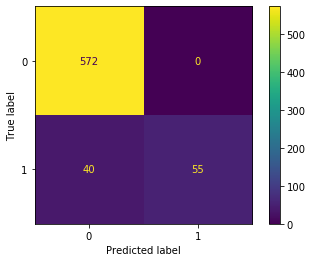

In [146]:
plot_confusion_matrix(forest_new,x_test,y_test,values_format='0.0f')
plt.show()

In [147]:
print('Classification report random forest classifier:\n',classification_report(y_test,forest_new.predict(x_test)))

Classification report random forest classifier:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97       572
           1       1.00      0.58      0.73        95

    accuracy                           0.94       667
   macro avg       0.97      0.79      0.85       667
weighted avg       0.94      0.94      0.93       667



We want to keep high churning rate customer from leaving. The cost of finding new customer is higher than retaining old customers, hence, we will try to maximize recall figure.

Based on data in US telecommunication industry, on average telecom subscriber spend around \\$887 per year on subscription. If let's say 1000 customers left company, company will suffer a revenue loss of \\$887,000 per year.

We want to make sure that the actual customer who will churn is given a $10 off of their subscription each month in order to make them stay. Since our model can capture 58% of customer who actually churn, we can  reduce our churning probability threshold to less than 0.5, so more customer who churn can be identified and retained.

### Export chosen model for deploy

In [145]:
joblib.dump(forest_new,'model')

['model']